In [11]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langgraph-supervisor
    Found existing installation: langgraph-supervisor 0.0.25
    Uninstalling langgraph-supervisor-0.0.25:
      Successfully uninstalled langgraph-supervisor-0.0.25
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-sonnet-4-20250514, claude-3-7-sonnet-latest")

In [274]:
# Auctions game theory 
# - Two agents (bidder1 and bidder2) bid for tasks based on their capabilities. 
# - Each agent shares their strengths using a player card. 
# - auctioneer decides which agent gets the task. 


# ---- Imports ----

import os
import time
import random
import json
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from typing import Literal, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Command, interrupt
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from pydantic import BaseModel
from pprint import pprint
from langchain.globals import set_debug


set_debug(False)
# ---- LLM Setup ----

# Load the default model from environment variables
openai_model = os.environ["OPENAI_MODEL"]
# Initialize the LLM (Large Language Model) interface
openai_llm = ChatOpenAI(model=openai_model)

# Load the default model from environment variables
anthropic_model = os.environ["ANTHROPIC_MODEL"]
# Initialize the LLM (Large Language Model) interface
anthropic_llm = ChatAnthropic(model=anthropic_model)

class OverallState(MessagesState):
    """State to track bidder's work."""
    
    selected_bidder_for_flood_report: Annotated[str, "selected player or bidder to generate report on flood based on the provided weather data"]
    selected_bidder_for_hurricane_report : Annotated[str, "selected player or bidder to generate report on hurricane based on the provided weather data"]
    final_report: Annotated[str, "final consolidated report generated by the auctioneer"]
    step: Annotated[int, "current step in the auction process"]
    weather_data : Annotated[str, "weather data provided as input"]
    feedback : Annotated[str, "human feedback on the final report"]

# Define a dummy luggage_support_tool
@tool
def get_player_card_tool(agent_name: Annotated[str, "name of the agent or player who is requesting their playercard."]):
    """Tool to fetch player card information for a given agent or player name."""
    
    player_cards = {
        "bidder1": {"flood_knowledge": random.randint(5, 8), "hurricane_knowledge": random.randint(3, 8), "response_time": random.randint(0, 3)},
        "bidder2": {"flood_knowledge": random.randint(3, 7), "hurricane_knowledge": random.randint(2, 9), "response_time": random.randint(0, 3)}
    }
    return player_cards.get(agent_name, {"error": "unknown player"})

class selected_bidders(BaseModel):
    """class to store the selected agents or players for flood and hurrican report generation."""
    selected_bidder_for_flood_report:  Annotated[str, "selected player or bidder to generate report on flood based on the provided weather data"]
    selected_bidder_for_hurricane_report:  Annotated[str, "selected player or bidder to generate report on hurricane based on the provided weather data"]
    selection_reasoning:  Annotated[str, "reason to choose a player or bidder for the task"]


class player_card(BaseModel):
    """class to store player or agents data."""
    player_name: Annotated[str, "name of the player or agent"]
    flood_knowledge_out_of_10 : Annotated[int, "flood knowledge out of 10"]
    hurricane_knowledge_out_of_10 : Annotated[int, "hurricane knowledge out of 10"]
    response_time_in_seconds: Annotated[int, "response time in seconds"] 

# Creating a generalized agent creation function to reduce redundancy
def create_bidder_player_card_agent(agent_name: str):
    """Creates a React agent for the bidder."""
    return create_react_agent(
        anthropic_llm,  
        tools=[get_player_card_tool],  
        prompt=f"You are a helpful agent, your name is {agent_name}. Your task is to get the player card data for yourself. You can use tools to get the data. ",
        response_format=player_card
    )

def create_prompt(input: MessagesState):
    return ("Based on the following data, choose the most suitable bidder to generate reports for flood and hurricane events. "
            "- Prioritize the knowledge of each bidder in the relevant subject (flood or hurricane) over their response time. "
            "- Response time should only be considered if two bidders have similar levels of expertise. "
            "- If bidders have identical knowledge levels, select the bidder with the shorter response time. "
            "- If bidders have the exact same knowledge and response time, you may randomly choose between them. "
            "- Provide a detailed explanation for your choice, including the reasons behind your decision-making process. "
            f"Here is the data: {input}")

get_selected_bidders = create_react_agent(
    anthropic_llm,  
    tools=[],  
    prompt=create_prompt, 
    response_format=selected_bidders
)

# Function to handle bidding process and generating responses
def handle_bidder_steps(agent_name: str, state: OverallState, step: str):
    """Handles the bidder's steps and actions based on the state."""
    
    if step == "step-1":
      
        response = create_bidder_player_card_agent(agent_name).invoke(state)
        player_card_data = response["structured_response"]
    
        return Command(
            goto=["auctioneer"],
            update={
                "messages": [
                    HumanMessage(content=f"{agent_name} response time in seconds : {player_card_data.response_time_in_seconds}", name=agent_name),
                    HumanMessage(content=f"{agent_name} flood knowledge out of 10 : {player_card_data.flood_knowledge_out_of_10}", name=agent_name),
                    HumanMessage(content=f"{agent_name} hurricane knowledge out of 10 : {player_card_data.hurricane_knowledge_out_of_10}", name=agent_name),
                    HumanMessage(content=f"{agent_name} shared the player card data", name=agent_name)
                ]
            }
        )
    
    if step == "step-2":

        for_flood = state["selected_bidder_for_flood_report"]
        for_hurricane = state["selected_bidder_for_hurricane_report"]
        
        if agent_name in (for_flood, for_hurricane):
          
            messages = [f" based on the following data generate a report on the given topic(s). Here is the data: {state["weather_data"]} "]
            
            topics = []
            if agent_name == for_flood:
                topics.append("flood")
            if agent_name == for_hurricane:
                topics.append("hurricane")
            if topics:
                messages += " Topics: " + ", ".join(topics)

            report = anthropic_llm.invoke(messages)

            return Command(
                goto=["auctioneer"],
                update={
                    "messages": [
                        HumanMessage(content=f"{agent_name} generated report(s) : {report.content} ", name=agent_name)
                    ]
                }
            )
        

        return Command(goto=["auctioneer"])
    
    
    return Command(
        goto=["auctioneer"],
        update={
            "messages": [
                HumanMessage(content=f"{agent_name} Unknown step", name=agent_name)
            ]
        }
    )
    

def bidder1(state: OverallState) -> Command[Literal["auctioneer"]]:
    """
    You are bidder1. 
    """
   
    step = state["messages"][-1].content
    return handle_bidder_steps("bidder1", state, step)
    

def bidder2(state: OverallState) -> Command[Literal["auctioneer"]]:
    """
    You are bidder2. 
    """
   
    step = state["messages"][-1].content
    return handle_bidder_steps("bidder2", state, step)
    

def human_review_node(state: OverallState) -> Command[Literal["auctioneer"]]:
    """
    Interrupt the flow to request human feedback on the report.
    Possible human actions: feedback, publish, update, delete.
    """
    human_review = interrupt({
        "ask": (
            "Please provide feedback (example: {'action': 'feedback', 'data': 'reduce size'}) "
            "Possible actions: [feedback, publish]"
        ),
        "report_to_review": state["final_report"]
    })

    review_action = human_review["action"]
    review_data = human_review["data"]

    if review_action == "publish":
        return Command(goto="auctioneer")
    
    if review_action == "feedback":
        return Command(goto="auctioneer", update={"feedback": review_data})
   
    return Command(goto="auctioneer")

def auctioneer(state: OverallState) -> Command[Literal["bidder1", "bidder2", "human_review_node",END]]:
    """
    initiate the gameplay
    """

    if(state["step"] == 1):
       
        next_step = state["step"] + 1

        return Command(
            goto=["bidder1", "bidder2"],
            update={
                "messages": [
                    HumanMessage(content=f"Share your player card data", name="auctioneer"),
                    HumanMessage(content=f"step-1", name="auctioneer")
                ],
                "step" : next_step}) 
   
    elif(state["step"] == 2):
       
        next_step = state["step"] + 1

        response = get_selected_bidders.invoke(state)
        selected_bidders_data = response["structured_response"]

        pprint(selected_bidders_data)

        return Command(
            goto=["bidder1", "bidder2"],
            update={
                "messages": [
                    HumanMessage(content=f"Selected bidder for the flood reporting : {selected_bidders_data.selected_bidder_for_flood_report}", name="auctioneer"),
                    HumanMessage(content=f"Selected bidder for the hurricane reporting : {selected_bidders_data.selected_bidder_for_hurricane_report}", name="auctioneer"),
                    HumanMessage(content=f"Selection reasoning : {selected_bidders_data.selection_reasoning}", name="auctioneer"),
                    HumanMessage(content="step-2", name="auctioneer")
                ],
                "selected_bidder_for_flood_report" : selected_bidders_data.selected_bidder_for_flood_report,
                "selected_bidder_for_hurricane_report" : selected_bidders_data.selected_bidder_for_hurricane_report,
                "step" : next_step}) 

    elif(state["step"] == 3):
       
        next_step = state["step"] + 1

        messages = (" Based on the message history, generate a final consolidated weather report on flood and hurricane. "
                    " Here is the message history: "
                    f"{state["messages"]}")
        
        final_report = anthropic_llm.invoke(messages)

        return Command(
            goto=["human_review_node"],
            update={
                "messages": [
                    HumanMessage(content=f"Final report: {final_report.content}", name="auctioneer")
                ],
                "final_report" : final_report.content,
                "step" : next_step
            })

    elif(state["step"] == 4):
               
        messages = (" Based on the following feedback, improve the weather report. If there is no feedback then return the report as it is. "
                    f"Human feeback: : {state["feedback"]} "
                    f"Original report: {state["final_report"]} ")
        
        final_report = anthropic_llm.invoke(messages)

        return Command(
            goto=[END],
            update={
                "messages": [
                    HumanMessage(content=f"Final report: {final_report.content}", name="auctioneer")
                ],
                "final_report" : final_report.content
            })  
    
    else:
        return Command(goto=[END]) 

In [275]:
# Build the state graph
graph_builder = StateGraph(OverallState)
graph_builder.add_node("auctioneer", auctioneer)
graph_builder.add_node("bidder1", bidder1)
graph_builder.add_node("bidder2", bidder2)
graph_builder.add_node("human_review_node", human_review_node)

# Define start 
graph_builder.add_edge(START, "auctioneer")

# Use MemorySaver as checkpointer (required for human interrupt/resume)
checkpointer = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=checkpointer)

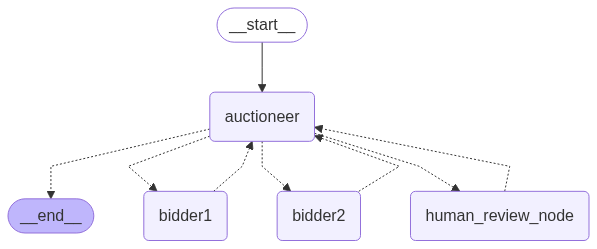

In [276]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [277]:
import uuid

# Assign a thread ID for the session
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

def get_weather_data():
    # Mock weather data for hurricane and flood
   
    weather_data = (" Hurricane data: "
                    "   Task Type: hurricane " 
                    "   Data: This includes information such as: " 
                    "       Storm Name: Hurricane Ida " 
                    "       Category: 4 " 
                    "       Wind Speed: 145 mph " 
                    "       Coordinates: Latitude: 25.5, Longitude: -81.5 " 
                    "       Forecast: Expected landfall date, affected areas (Florida, Georgia, South Carolina), and warnings for evacuation orders. " 
                    " Flood data: " 
                    "   Task Type: Flood " 
                    "   Data: This includes information such as: " 
                    "       Flood Warning: True " 
                    "       Affected Regions: Southern Texas, Louisiana " 
                    "       Rainfall Data: 24-hour rainfall (10.5 inches), total rainfall over the last 72 hours (30.1 inches) " 
                    "       River Levels: Mississippi River, with current level and flood stage details. " 
                    "       Forecast: Expected peak river level (36.0 feet) and evacuation orders. " )
    return weather_data


weather_data = get_weather_data()

for s in graph.stream(
    {"messages": [("user", " Find best agent or bidder for the tasks. ")],
     "step": 1,
     "weather_data" : weather_data}, 
     config=thread_config):
    pprint(s)
    pprint("============================")


# Resume: Human gives feedback to "add emojis"
for s in graph.stream(
    Command(resume={"action": "feedback", "data": "add emojis to the report"}),
    config=thread_config
):
    pprint(s)
    pprint("============================")



{'auctioneer': {'messages': [HumanMessage(content='Share your player card data', additional_kwargs={}, response_metadata={}, name='auctioneer', id='75ca30de-1850-477b-bddc-9ac78db9a042'),
                             HumanMessage(content='step-1', additional_kwargs={}, response_metadata={}, name='auctioneer', id='826f8b14-a7c0-44d8-8a39-67f7dcfe8821')],
                'step': 2}}
'============================'
{'bidder2': {'messages': [HumanMessage(content='bidder2 response time in seconds : 3', additional_kwargs={}, response_metadata={}, name='bidder2'),
                          HumanMessage(content='bidder2 flood knowledge out of 10 : 6', additional_kwargs={}, response_metadata={}, name='bidder2'),
                          HumanMessage(content='bidder2 hurricane knowledge out of 10 : 4', additional_kwargs={}, response_metadata={}, name='bidder2'),
                          HumanMessage(content='bidder2 shared the player card data', additional_kwargs={}, response_metadata={}, name=